In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time

In [ ]:
!uv pip install -q --system numba-cuda==0.4.0

In [ ]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0

In [ ]:
from numba import cuda
from PIL import Image, ImageOps
import numpy as np
import math
import matplotlib.pyplot as plt

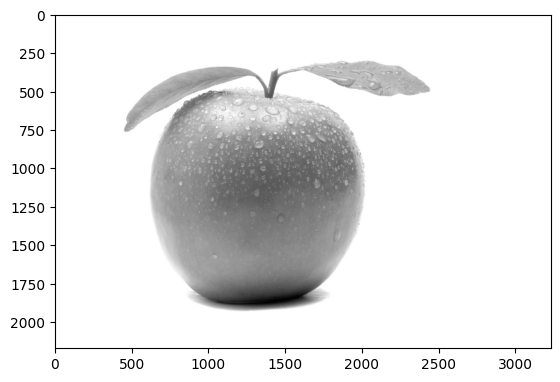

In [ ]:
image = ImageOps.grayscale(Image.open('/content/drive/MyDrive/apple.jpg'))
image = np.asarray(image)
plt.imshow(image, cmap = 'gray')

In [ ]:
imageH = image.shape[0]
imageW = image.shape[1]

In [ ]:
blockSize = (32,32)
gridSize = (imageH // blockSize[0] + 1, imageW // blockSize[1] + 1)

In [ ]:
stdev = 0.05
d_host = cuda.to_device(image)
d_image = cuda.device_array_like(image)

In [ ]:
kernel = np.zeros((7,7),dtype = np.float32)
d_kernel = cuda.to_device(kernel)

In [ ]:
import math
@cuda.jit
def gaussian_blur(layer, stdev):
  tidx = cuda.threadIdx.x
  tidy = cuda.threadIdx.y
  meanx = layer.shape[0] // 2
  meany = layer.shape[1] // 2

  layer[tidx,tidy] = ( 1/( 2*math.pi*(stdev**2)))*math.exp(-( (tidx-meanx)**2 + (tidy-meany)**2) / ( 2*(stdev**2) ))


In [ ]:
gaussian_blur[(1,),d_kernel.shape](d_kernel,stdev)

In [ ]:
rest = d_kernel.copy_to_host()
print(rest)

[[ 0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.       63.661976  0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.      ]]


In [ ]:
@cuda.jit
def convolve(img, layer, res):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  # Boundary checking: if the thread coordinates are outside of the image, ignore the thread.
  if (i >= tidx) or (j >= tidy):
        return
  delta_tidx = layer.shape[0] // 2
  delta_tidy = layer.shape[1] // 2

  conv_sum = 0
  for i in range (layer.shape[0]):
    for j in range(layer.shape[1]):
      in_x = tidx - i + delta_tidx
      in_y = tidy - j + delta_tidy
      if (in_x >=0) and (in_x < img.shape[0]) and (in_y >=0) and (in_y < img.shape[1]):
        conv_sum += layer[i,j] * img[in_x,in_y]
  res[tidx,tidy] = conv_sum

In [ ]:
start = time.time()
convolve[gridSize,blockSize](d_host, d_kernel ,d_image)
end = time.time() - start
print("Finished in: ", end)

Finished in:  0.0006742477416992188


In [ ]:
result = d_image.copy_to_host()

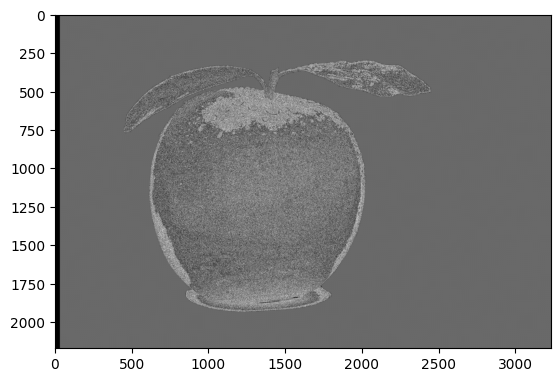

In [ ]:
plt.imshow(result, cmap = 'gray')

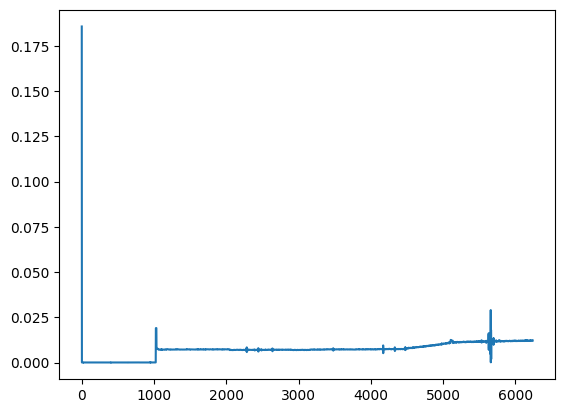

In [ ]:
plt.plot(steps, ends)
plt.show()

## Shared memory

In [ ]:
@cuda.jit
def shared_blur(input,output,kernel):
  tile_image = cuda.shared.array(shape = (7,7), dtype = np.uint8)

  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  tile_image[cuda.threadIdx.x, cuda.threadIdx.y] = input[tidx,tidy]

  cuda.syncthreads()

  if (tidx >= output.shape[0]) or (tidy >= output.shape[1]):
    return

  delta_tidx = kernel.shape[0] // 2
  delta_tidy = kernel.shape[1] // 2

  conv_sum = 0
  for i in range (kernel.shape[0]):
    for j in range(kernel.shape[1]):
      in_x = tidx - i + delta_tidx
      in_y = tidy - j + delta_tidy
      if (in_x >=0) and (in_x < output.shape[0]) and (in_y >=0) and (in_y < output.shape[1]):
        conv_sum += kernel[i,j] * input[in_x,in_y]
  output[tidx,tidy] = conv_sum



In [ ]:
start = time.time()
shared_blur[gridSize,blockSize](d_host,d_image,d_kernel)
end = time.time() - start
print("Finished in: ", end)

Finished in:  0.0008153915405273438


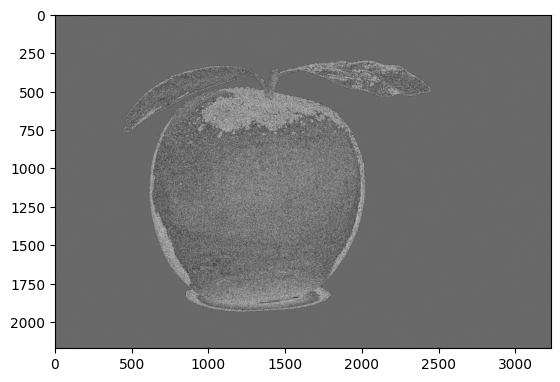

In [ ]:
res2 = d_image.copy_to_host()
plt.imshow(res2, cmap = 'gray')